<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

This Jupyter notebook demonstrates the use of the `urrogate_schema`library to perform a specific parametric building energy analysis on AWS Batch. It starts by defining a parameter space and generating manually a set of samples within that space. 

A pre-existing BuildingAnalysis object is loaded, which specifies the analysis that has already been performed. If you wish, you can uncomment the lines and the necessary files are uploaded to S3. The job is then submitted to AWS Batch, and the status of the job is tracked.

Finally, the results of the job are retrieved and saved to a JSON file.

In [1]:
from surrogate_schema import __version__

__version__

'0.15.5.dev2+g7d66ffc.d20240322'

In [2]:
from surrogate_schema import APIClient, BuildingAnalysis, SampledSpace, Space

%load_ext dotenv
%dotenv

# typical block to authenticate to the API
client = APIClient(api_url="https://api.elementa.nyc")
client.whoami()  # shows that you are properly authenticated

User(username='s.letellierduchesne', email='sam@cabonsignal.com', full_name='Samuel Letellier-Duchesne', disabled=None, valid_until=datetime.datetime(2025, 1, 29, 20, 28, 26))

The next cell creates a Space object which defines the dimensions of the parameter space to be explored.

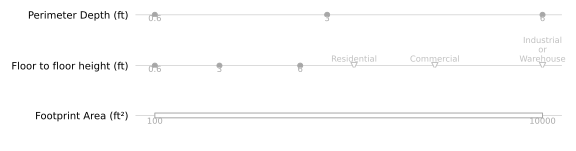

In [3]:
space = Space(
    dimensions=[
        dict(name="FOOTPRINT_AREA", low=100, high=10_000),
        dict(name="PERIM_DEPTH", categories=[0.6, 3, 6]),
        dict(name="FLOOR_TO_FLOOR_HEIGHT", categories=[0.6, 3, 6]),
    ]
)
space

A SampledSpace object is created, which generates a list of samples in the defined Space. The samples are then converted to a Pandas DataFrame to be viewed.

In [4]:
ss = SampledSpace(
    space=space,
    X=[
        [10000, 3, 3],
        [400, 3, 3],
        [100, 3, 3],
        [400, 0.6, 3],
        [400, 3, 3],
        [400, 6, 3],
        [400, 0.6, 0.6],
        [400, 3, 3],
        [400, 6, 6],
    ],
)
ss.to_df()

,FOOTPRINT_AREA,PERIM_DEPTH,FLOOR_TO_FLOOR_HEIGHT
0,10000,3.0,3.0
1,400,3.0,3.0
2,100,3.0,3.0
3,400,0.6,3.0
4,400,3.0,3.0
5,400,6.0,3.0
6,400,0.6,0.6
7,400,3.0,3.0
8,400,6.0,6.0


The next cell loads an existing BuildingAnalysis object from a JSON file. If you want to create a new BuildingAnalysis object, you can uncomment the necessary code in this cell and run it.

In [5]:
analysis = BuildingAnalysis.model_validate_json(open("./analysis.json").read())

# analysis = BuildingAnalysis(
#     company="Carbon Signal",
#     project="Experiment",
#     local_epw="./USA_MA_Boston-Logan.Intl.AP.725090_TMY3.epw",
#     local_ddyname="./USA_MA_Boston-Logan.Intl.AP.725090_TMY3.ddy",
#     local_template="./BostonTemplateLibrary.json",
#     hvac_template_name=SupportedHVACTemplate.SimpleIdealLoadsSystem,
#     design_space=space,
#     sampled_space=ss,
#     baseline={"FOOTPRINT_AREA": 400, "PERIM_DEPTH": 3.0, "FLOOR_TO_FLOOR_HEIGHT": 3.0}
# )

The following cell prepares a job to run on AWS Batch by uploading necessary files to S3. The `prepare_job` method takes arguments such as the job definition and whether or not to upload simulation files to S3 (if you wish to retreive them later, otherwise they are deleted).

In [6]:
analysis.prepare_job(upload_to_s3=True, job_definition="energyplus-22-1-0")

[GenerateAndRunJob(parameters=Parameters(log_level=<LogLevel.INFO: 'INFO'>, run_number=None, parameters=Url('s3://surrogate-api/parametric/8177bcc0-c032-43a5-a1a5-df85d6a4f9b1/parameters.json'), prototype_model=None, form_factor=None, template_library=Url('s3://surrogate-api/parametric/8177bcc0-c032-43a5-a1a5-df85d6a4f9b1/BostonTemplateLibrary.json'), ddy_file=None, idf_output_dir=Url('s3://surrogate-api/parametric/8177bcc0-c032-43a5-a1a5-df85d6a4f9b1/idfs/'), output_meters=None, output_variables=None, include=None, table_name='single-building-analysis', start_index='0', reporting_frequency='Monthly', upload_to_s3=True), jobName='parametric_8177bcc0-c032-43a5-a1a5-df85d6a4f9b1', jobQueue='dev', arrayProperties=ArrayProperty(size=9), tags={'Project': 'Experiement', 'Company': 'Carbon Signal', 'SubmittedBy': 'sam@cabonsignal_com'}, propagateTags=True, containerOverrides=ContainerOverrides(command=['--log-level', 'Ref::log_level', 'generate-idf-and-run', '--parameters', 'Ref::parameters',

In the next cell, the job is submitted to AWS Batch with the submit_job method.

In [9]:
analysis.submit_job()

[SubmitJobResponse(jobArn='arn:aws:batch:us-east-2:664685589714:job/d8699719-a3b4-4358-9678-6de87a417ce1', jobName='parametric_8177bcc0-c032-43a5-a1a5-df85d6a4f9b1', jobId=UUID('d8699719-a3b4-4358-9678-6de87a417ce1'))]

After submitting the job, the save method is used to save the BuildingAnalysis object to a JSON file.

In [10]:
analysis.save("analysis.json")

The next cell uses the `track_status` method to check the status of the running job.

In [12]:
analysis.track_status()

0it [00:00, ?it/s]

Finally, the `get_results` method is used to retrieve the results of the job.

In [13]:
results = analysis.get_results()
results.to_df()

,FOOTPRINT_AREA,PERIM_DEPTH,FLOOR_TO_FLOOR_HEIGHT,EUI_kBtu_per_sqft,TEDI_kBtu_per_sqft,CEDI_kBtu_per_sqft,EDI_kBtu_per_sqft,sensible_peak_cooling_W_per_sqft,sensible_peak_heating_W_per_sqft,time_of_peak_cooling,time_of_peak_heating,peak_heating_W_per_sqft,peak_cooling_W_per_sqft
0,10000.0,3.0,3.0,44.121598,6.806808,16.430935,23.237743,3.067708,0.453987,11-JUL-15:20,23-JAN-06:00,2.403398,4.594588
1,400.0,3.0,3.0,70.428733,17.724486,31.819716,49.544202,6.561165,3.095764,11-JUL-15:20,23-JAN-06:00,5.033177,7.725053
2,100.0,3.0,3.0,98.820113,27.575870,50.359712,77.935582,10.824354,5.882142,11-JUL-15:20,23-JAN-06:00,7.819556,11.804886
3,400.0,0.6,3.0,65.900844,12.845813,32.170500,45.016313,6.213178,2.263662,11-JUL-16:00,23-JAN-06:00,4.201087,7.416243
4,400.0,3.0,3.0,70.428733,17.724486,31.819716,49.544202,6.561165,3.095764,11-JUL-15:20,23-JAN-06:00,5.033177,7.725053
5,400.0,6.0,3.0,71.158324,18.140407,32.133386,50.273793,6.733045,3.252131,11-JUL-15:50,23-JAN-06:00,5.189545,7.916334
6,400.0,0.6,0.6,49.271087,10.460734,17.925822,28.386556,3.444500,0.976732,11-JUL-16:00,23-JAN-06:00,2.914145,4.864459
7,400.0,3.0,3.0,70.428733,17.724486,31.819716,49.544202,6.561165,3.095764,11-JUL-15:20,23-JAN-06:00,5.033177,7.725053
8,400.0,6.0,6.0,99.416408,29.431862,49.100015,78.531877,10.766615,6.196215,11-JUL-15:20,23-JAN-06:00,8.133641,11.841062
